Equiripple / Remez Design Algorithm: Introduction
--------------

In this section, we consider another approach to the filter design problem as solving for an optimal Chebyshev polynomial. In broad strokes, the idea is to approximate the desired  filter response by a *minimax* polynomial, one with a minimal maximum deviation from the ideal desired response, $H_{d}(\omega) $. It turns out that solving for such polynomials employs the *Remez exchange algorithm* so the implemented function in the `signal.fir_filter_design` is called `remez`, even though the application of this algorithm to FIR filter design is just part of the  Parks-McClellan algorithm. Unfortunately, the algorithm itself is based on certain advanced theorems beyond our scope so we will just use it to get acceptable filter coefficients.

This notebook is based mostly on https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Filtering_Part3.ipynb

## Filter Specification


The Parks-McClellan algorithm generates filter coefficients by solving the *optimum equiripple Chebyshev approximation* to the ideal filter provided in the specification.  The Parks-McClellan algorithm internally uses the Remez exchange technique so the corresponding function in the `signal` module is called `signal.remez`. The function takes the `numtaps` argument which is $M$ in our notation, the `bands` argument is a sequence of passband/stopband edges in normalized frequency (i.e. scaled  by $f_s/2$), the `desired` argument is a `numpy` array (or other array-like iterable ) that is half the length of the `bands` argument and contains the desired gain in each of the specified bands. The next argument is the optional `weight` which is array-like, half the length of the `bands` argument, and provides the relative weighting for the passband/stopband. The unfortunately named optional `Hz` argument (default=1) is the sampling frequency in the same units as the `bands`. The next optional argument is the type of filter response in each of the bands (i.e. bandpass, hilbert). The default is `bandpass` filter. The remaining arguments of the function call have to do with the internal operation of the iterative algorithm.

Now, let's see this approach in action.

### Example

Suppose we operate at a 1 kHz sample rate and we want a 20-tap lowpass filter with a passband up to 100 Hz and a stopband starting at 150 Hz. 

C:\Users\Christian\AppData\Local\Temp\ipykernel_9156\1348731920.py:15: DeprecationWarning: 'remez' keyword argument 'Hz' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  hn = signal.remez(M,


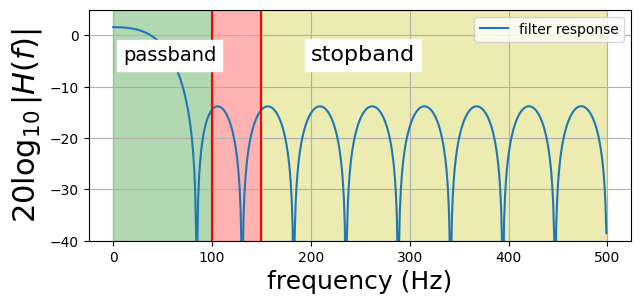

In [1]:
from __future__ import  division
from numpy import angle, arange, array, cos, fft, linspace, log10, pi, ones, sin, sinc
from scipy import signal
#import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, subplot, subplots, subplots_adjust, show
from matplotlib.patches import Rectangle

%matplotlib inline

fs = 1e3 # sample rate in Hz
M = 20
fpass = 100 # in Hz
fstop = 150 # in Hz

hn = signal.remez(M,
                 array([0, fpass, fstop, fs])/2., # scaled passband, and stop band 
                 [1,0],  # low pass filter
                 Hz = fs, # sampling frequency
                 )

w, H = signal.freqz(hn, 1) # frequency response

def apply_plot_overlay():
    'convenience function to illustrate stop/passband in frequency response plot'
    ax.plot(w/pi*(fs/2), 20*log10(abs(H)), label='filter response')
    ax.set_ylim(ymax=5)
    ax.vlines(100, *ax.get_ylim(), color='r')
    ax.vlines(150, *ax.get_ylim(), color='r')
    ax.set_ylim(ymin=-40)
    ax.set_xlabel("frequency (Hz)", fontsize=18)
    ax.set_ylabel(r"$20\log_{10}|H(f)|$", fontsize=22)
    ax.add_patch(Rectangle((0,-40), width=fpass, height=45, color='g', alpha=0.3))
    ax.add_patch(Rectangle((fpass,-40), width=fstop-fpass, height=45, color='r', alpha=0.3))
    ax.add_patch(Rectangle((fstop,-40), width=fs/2-fstop, height=45, color='y', alpha=0.3))
    ax.text(10, -5, 'passband', fontsize=14, bbox=dict(color='white'))
    ax.text(200, -5, 'stopband', fontsize=16, bbox=dict(color='white'))
    ax.grid()
    
fig, ax = subplots()
fig.set_size_inches((7, 3))
apply_plot_overlay()
ax.legend(loc = 'best');

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The figure above shows the frequency response for the specified FIR filter. The pink region is the transitional region between the pass and stop bands. As shown, the attenuation in the stopband only provides approximately 15 dB of attenuation. This means that a signal greater than 15 dB in the stopband will leak into the signals in the passband.  One way to increase the attenuation in the stopband, is to increase the filter order,  $M$, as shown in the figure below.

C:\Users\Christian\AppData\Local\Temp\ipykernel_9156\529135646.py:2: DeprecationWarning: 'remez' keyword argument 'Hz' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  hn = signal.remez(M,


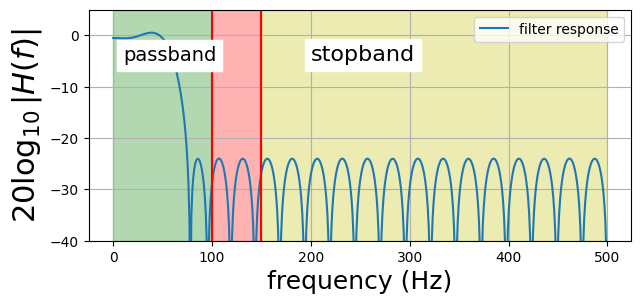

In [2]:
M = 40 # double filter length
hn = signal.remez(M,
                 array([0, fpass, fstop, fs])/2., # scaled passband, and stop band 
                 [1,0],  # low pass filter
                 Hz = fs, # sampling frequency
                 )

w, H = signal.freqz(hn, 1) # frequency response

fig, ax = subplots()
fig.set_size_inches((7, 3))
apply_plot_overlay()
ax.legend(loc = 'best');

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The figure above shows the frequency response when the filter order is doubled. Note that the attenuation in the stopband has improved but there is now a significant distortion due to the ripple in the passband. Given the same filter order, $ M $, we can mitigate this with the `weight` argument as shown below.

C:\Users\Christian\AppData\Local\Temp\ipykernel_9156\904014295.py:1: DeprecationWarning: 'remez' keyword argument 'Hz' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  hn = signal.remez(M,


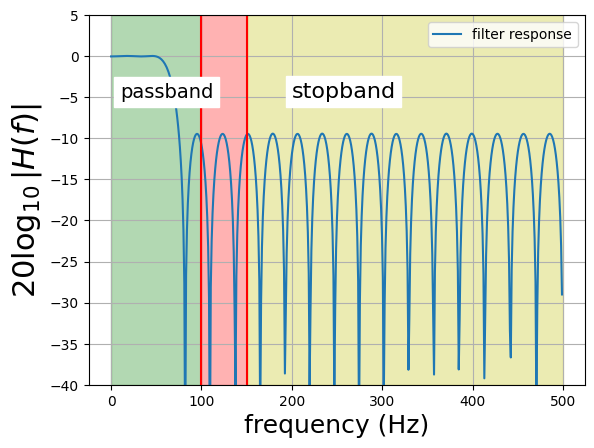

In [3]:
hn = signal.remez(M,
                 array([0, fpass, fstop, fs])/2., # scaled passband, and stop band 
                 [1,0],  # low pass filter
                 weight=[100,1], # passband 100 times more important than stopband
                 Hz = fs, # sampling frequency
                 )

w, H = signal.freqz(hn, 1) # frequency response
fig,ax = subplots()
#fig.set_size_inches((7, 3))
apply_plot_overlay()
ax.legend(loc = 'best');

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


As the figure above shows, using the `weight` argument allows flattening of the passband at the expense of raising the stopband attenuation.  This argument influences the iterative algorithm to value errors in the passband much more than in the stopband. Experiment with different filter orders and weights.

Let's now consider the performance of this filter in practice.


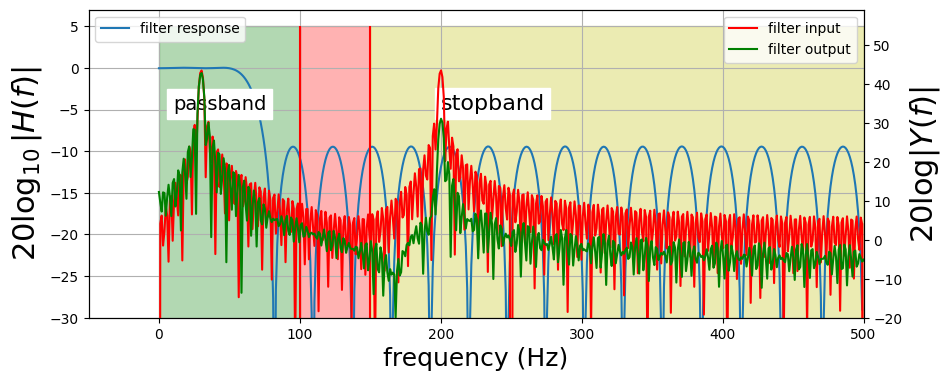

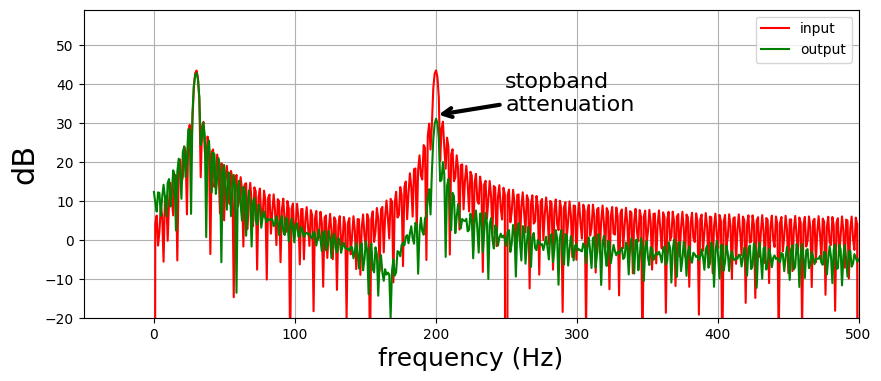

In [4]:
Ns = 300 # number of samples 
N = 1024 # DFT size
t = arange(0, Ns)/fs

x = cos(2*pi*30*t) + cos(2*pi*200*t)
#x = x*signal.hamming(Ns) # try windowing also!
X = fft.fft(x, N)

y = signal.lfilter(hn,1,x)
Y = fft.fft(y, N)

fig, ax = subplots()
fig.set_size_inches((10, 4))
apply_plot_overlay()
ax.set_ylim(ymin=-30,ymax=7)
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(arange(N)/N*fs,20*log10(abs(X)),'r-',label='filter input')
ax2.plot(arange(N)/N*fs,20*log10(abs(Y)),'g-',label='filter output')
#ax2.plot(arange(N)/N*fs,20*log10(abs(X)*abs(H)),'g:',lw=2.,label='YY')
ax2.set_xlim(xmax = fs/2)
ax2.set_ylim(ymin=-20)
ax2.set_ylabel(r'$20\log|Y(f)|$',fontsize=22)
ax2.legend(loc=0);

fig,ax = subplots()
fig.set_size_inches((10,4))
ax.plot(arange(N)/N*fs,20*log10(abs(X)),'r-',label='input')
ax.plot(arange(N)/N*fs,20*log10(abs(Y)),'g-',label='output')
ax.set_xlim(xmax = fs/2)
ax.set_ylim(ymin=-20)
ax.set_ylabel(r'dB',fontsize=22)
ax.set_xlabel("frequency (Hz)",fontsize=18)
ax.grid()
ax.annotate('stopband\nattenuation',fontsize=16,xy=(200,32),
             xytext=(50,3),textcoords='offset points',
             arrowprops=dict(arrowstyle='->',lw=3),
            )
ax.legend(loc=0);

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The figure above shows an overlay of the filter response (in blue, left-side y-axis) on the input and output of the filter (right-side y-axis) where the input consists of two equal-amplitude tones, one in the passband and one in the stopband. Because the filter's stopband provides approximately 10 dB of attenuation, the tone in the stopband is reduced by this amount. Note that the tone in the passband remains unchanged because the passband attenuation is negligible (as it was designed!). The bottom plot in the figure above is the same thing except without the overlay.

Let's consider the input and output signals in the time domain in the following figure.

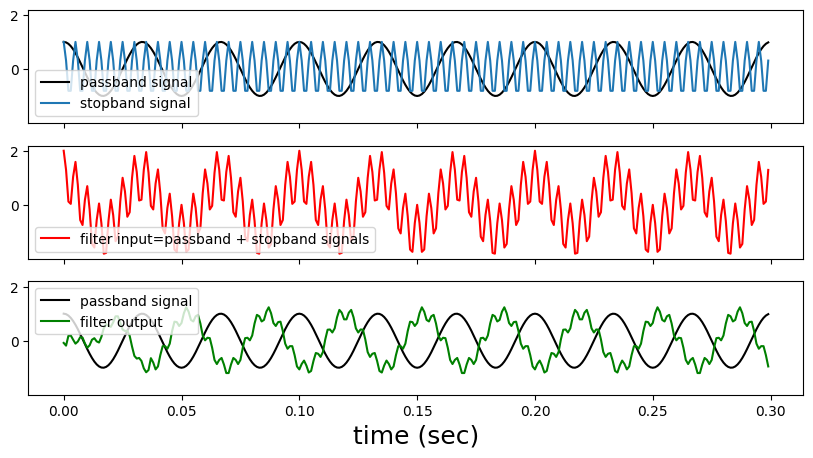

In [5]:
x_pass = cos(2*pi*30*t) # passband signal
x_stop = cos(2*pi*200*t) # stopband signal
x = x_pass + x_stop
y=signal.lfilter(hn,1,x)

fig,axs = subplots(3,1,sharey=True,sharex=True)
fig.set_size_inches((10,5))

ax=axs[0]
ax.plot(t,x_pass,label='passband signal',color='k')
ax.plot(t,x_stop,label='stopband signal')
ax.legend(loc=0)

ax=axs[1]
ax.plot(t,x,label='filter input=passband + stopband signals',color='r')
ax.legend(loc=0)

ax=axs[2]
ax.plot(t,x_pass,label='passband signal',color='k')
ax.plot(t,y,label='filter output',color='g')
ax.set_xlabel("time (sec)",fontsize=18)
ax.legend(loc=0);

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The figure above beaks down the time-domain response of the filter. The top plot shows the two signals separately. The middle figure shows the sum of these two signals that is the filter's input. The bottom plot shows the filter's output compared to the input signal that was in the filter's passband.

In the bottom plot, observe that the output signal is shifted compared to the input. This is due the phase response of the filter. Because this is a linearphase FIR filter, this phase is linear. Also notice that the stopband signal that causes the ripple on the filter's output is still obvious in the filter's output. This is a result of the relatively poor 10 dB attenuation in the stopband that we noted earlier. If we want to eliminate this rippling effect entirely, we have to design a filter with much greater  attenuation in the stopband.

Change the amplitude of the signal in the stopband and see how it affects the filter's output.

## Summary

In this section, we covered the the Parks-McClellan algorithm that generates FIR filter coefficients by solving the optimum equiripple Chebyshev approximation to the ideal filter provided in the specification. This design technique as implemented in the `signal.remez` function allows the designer to specify the passband and stopband frequencies, the idealized response in the passband, and optional relative weighting of the desired response in the passband as opposed to the stopband. All of these filter design techniques are subject to the *stuffed mattress effect* which means that pushing the filter's response down in one area (i.e. increasing attenuation in the stopband) just pushes it up elsewhere in the frequency domain, potentially causing passband distortion as we illustrated. It is the designer's responsibility to reconcile these competing demands for filter performance in terms of the overarching cost of complexity (i.e. filter length, numerical precision of coefficients) that may dominate the filters implementation in hardware.

One thing we did not discuss is how to pick the filter order given a desired passband/stopband specification.  Unfortunately, this is left to trial and error and the intuition of the filter designer. Note that there are many other ways to design FIR filters, each in interpreting the FIR design problem differently.  For example, the *pyFDA* program implements constraint-based filter designs.

As usual, the corresponding IPython notebook for this post  is available for download [here](https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Filtering_Part3.ipynb). 

Comments and corrections welcome!

References
---------------

* J. H. McClellan and T. W. Parks, “A unified approach to the design of optimum FIR linear phase digital filters”, IEEE Trans. Circuit Theory, vol. CT-20, pp. 697-701, 1973.
* J. H. McClellan, T. W. Parks and L. R. Rabiner, “A Computer Program for Designing Optimum FIR Linear Phase Digital Filters”, IEEE Trans. Audio Electroacoust., vol. AU-21, pp. 506-525, 1973.
